This script is used to produce Figure 2 (change in mean bloom start, end, and length between 1970 and 2050/2100) and Figure SX (change in variability in bloom start, end, and length between 1970 and 2050/2100) for the Payne et al. paper "XXX". 

1. Import Packages

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import math
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import xesmf as xe

2. Read in a randomly chosen NPP file. This is used to generate latitude (lat) and longitude (lon) fields for CESM files.

In [2]:
# Select a file
vdir = 'ocn'
vnam = 'photoC_diat_zint_2'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'
fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

# Interpolate lat and lon values over holes in the arrays
ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)


In [4]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 50:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
arctic_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(ncfile['photoC_diat_zint_2'][180,i,j]) == False and ncfile["TLAT"][i,j] > 66.5:
            arctic_ocn[i,j] = areacello[i,j]
            

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


3. Read in bloom start (max_25) and end (max_25_2) files. These files were created for each year and across all ensemble members using the "BloomMetrics" script. Bloom start occurs on the date when biomass first surpasses 25% of the maximum biomass at any given grid cell, and end occurs on the date when biomass first diminishes below 25% of the maximum following the peak in biomass. Afterwards, I set all bloom start and end values to 'nan' if they are equal to zero.

In [5]:
max_25 = np.zeros([14,384,320,50]); max_25_2 = np.zeros([14,384,320,50]); 
for yrset in np.arange(0,14):
    yrnum = str(1970 + yrset*10)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25.txt")
    max_25[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25_2.txt")
    max_25_2[yrset,:,:,:] = dir.reshape(384,320,50)

max_25 = np.where(max_25==0, np.nan, max_25)
max_25_2 = np.where(max_25_2==0, np.nan, max_25_2)

In [6]:
# a. Read in a shapefile of the sea ice masks (perennial ice, seasonal ice, open water)
ds_simask = xr.open_dataset("/glade/u/home/cpayne/Projects/BloomLength/Input/simask.nc")
si_clim = ds_simask["si_clim"]
si_ens = ds_simask["si_ens"]

In [7]:
si1970 = np.full([384,320],np.nan); siyr = np.full([384,320],np.nan); 
sichange = np.full([384,320],np.nan)
yr1 = 5 #5 = 2020, 8 = 2050, 13 = 2100
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            si1970[i,j] = np.round(np.nanmean(si_ens[:,0,i,j]),0)
            siyr[i,j] = np.round(np.nanmean(si_ens[:,yr1,i,j]),0)
            if si1970[i,j] == 0:
                if siyr[i,j] == 0:
                    sichange[i,j] = 0 #Ice free -> ice free
                if siyr[i,j] == 1:
                    sichange[i,j] = 1 #Ice free -> seasonal
                if siyr[i,j] == 2:
                    sichange[i,j] = 2 #Ice free -> perennial
            if si1970[i,j] == 1:
                if siyr[i,j] == 0:
                    sichange[i,j] = 3 #Seasonal -> ice free
                if siyr[i,j] == 1:
                    sichange[i,j] = 4 #Seasonal -> seasonal
                if siyr[i,j] == 2:
                    sichange[i,j] = 5 #Seasonal -> perennial
            if si1970[i,j] == 2:
                if siyr[i,j] == 0:
                    sichange[i,j] = 6 #Perennial -> ice free
                if siyr[i,j] == 1:
                    sichange[i,j] = 7 #Perennial -> seasonal
                if siyr[i,j] == 2:
                    sichange[i,j] = 8 #Perennial -> perennial

In [8]:
si_zone = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if sichange[i,j] == 1 or sichange[i,j] == 2 or sichange[i,j] == 4 or sichange[i,j] == 5 or sichange[i,j] == 7 or sichange[i,j] == 8:
            si_zone[i,j] = areacello_ocn[i,j]

In [11]:
import numpy.ma as ma
max_25_simean = np.zeros([50]); max_25_simean2 = np.zeros([50])
yr = 13
for ens in np.arange(0,50):
    max_25_simean[ens] = np.nansum((max_25_2[0,:,:,ens]-max_25[0,:,:,ens]) * si_zone)/np.nansum(si_zone)
    max_25_simean2[ens] = np.nansum((max_25_2[yr,:,:,ens]-max_25[yr,:,:,ens]) * si_zone)/np.nansum(si_zone)


In [44]:
print(np.mean(max_25_simean),np.mean(max_25_simean2),np.mean(max_25_simean)-np.mean(max_25_simean2),np.std(max_25_simean))

71.43135955757438 90.51519555765287 -19.08383600007849 3.2577020406077546


In [41]:
print(np.mean(max_25_simean),np.mean(max_25_simean2),np.mean(max_25_simean)-np.mean(max_25_simean2),np.std(max_25_simean))

65.07366982239141 60.068034407252796 5.005635415138613 9.060905649058482


In [58]:
print(stats.ttest_rel(max_25_simean2, max_25_simean))

TtestResult(statistic=-18.77512148679489, pvalue=5.024393538777195e-24, df=49)


In [70]:
print(stats.ttest_rel(max_25_2[0,i,j,:]-max_25[0,i,j,:], max_25_2[5,i,j,:]-max_25[5,i,j,:]))

TtestResult(statistic=nan, pvalue=nan, df=nan)


In [28]:
yr = 5
max_25_mean = np.zeros([50]);max_25_mean2 = np.zeros([50]);
for ens in np.arange(0,50):
    max_25_mean[ens] = np.nansum((max_25_2[0,:,:,ens]-max_25[0,:,:,ens]) * arctic_ocn)/np.nansum(arctic_ocn)
    max_25_mean2[ens] = np.nansum((max_25_2[yr,:,:,ens]-max_25[yr,:,:,ens]) * arctic_ocn)/np.nansum(arctic_ocn)

In [29]:
print(np.mean(max_25_mean),np.mean(max_25_mean2), np.mean(max_25_mean)-np.mean(max_25_mean2))
print(stats.ttest_rel(max_25_mean, max_25_mean2))

67.49520606036566 67.8057253197892 -0.3105192594235433
TtestResult(statistic=-0.509294614735527, pvalue=0.6128317454002563, df=49)


In [27]:
print(np.mean(max_25_mean),np.mean(max_25_mean2), np.mean(max_25_mean)-np.mean(max_25_mean2))
print(stats.ttest_rel(max_25_mean, max_25_mean2))

67.49520606036566 81.9799307582967 -14.484724697931043
TtestResult(statistic=-15.807399288147138, pvalue=7.115481324707811e-21, df=49)


In [32]:
yr = 13
max_25_mean = np.zeros([50]);max_25_mean2 = np.zeros([50]);
for ens in np.arange(0,50):
    max_25_mean[ens] = np.nansum((max_25_2[0,:,:,ens]-max_25[0,:,:,ens]) * areacello_ocn)/np.nansum(areacello_ocn)
    max_25_mean2[ens] = np.nansum((max_25_2[yr,:,:,ens]-max_25[yr,:,:,ens]) * areacello_ocn)/np.nansum(areacello_ocn)

In [31]:
print(np.mean(max_25_mean),np.mean(max_25_mean2), np.mean(max_25_mean)-np.mean(max_25_mean2))
print(stats.ttest_rel(max_25_mean, max_25_mean2))

69.7321304900764 68.7080293090138 1.0241011810626048
TtestResult(statistic=2.673624906162071, pvalue=0.010165634380969032, df=49)


In [33]:
print(np.mean(max_25_mean),np.mean(max_25_mean2), np.mean(max_25_mean)-np.mean(max_25_mean2))
print(stats.ttest_rel(max_25_mean, max_25_mean2))

69.7321304900764 76.03721856974157 -6.305088079665168
TtestResult(statistic=-9.544014428163948, pvalue=9.25956037773927e-13, df=49)


In [9]:
import numpy.ma as ma
max_25_arcmean = np.zeros([50]); max_25_arc = np.zeros([384,320,50])
yr = 0
for ens in np.arange(0,50):
    max_25_arc[:,:,ens] = ma.masked_array(max_25[yr,:,:,ens], lat < 66.5)#-max_25[yr,:,:,ens]
    arc_ocn = ma.masked_array(areacello_ocn, lat < 66.5)
    max_25_arcmean[ens] = np.nansum(max_25_arc[:,:,ens] * arc_ocn)/np.nansum(arc_ocn)

max_25_arcmean2 = np.zeros([50]); max_25_arc = np.zeros([384,320,50])
yr = 5
for ens in np.arange(0,50):
    max_25_arc[:,:,ens] = ma.masked_array(max_25[yr,:,:,ens], lat < 66.5)#-max_25[yr,:,:,ens]
    arc_ocn = ma.masked_array(areacello_ocn, lat < 66.5)
    max_25_arcmean2[ens] = np.nansum(max_25_arc[:,:,ens] * arc_ocn)/np.nansum(arc_ocn)


In [85]:
print(np.mean(max_25_arcmean),np.std(max_25_arcmean))

163.1317429733573 2.587856696526508


In [86]:
print(np.mean(max_25_arcmean2)-np.mean(max_25_arcmean),np.std(max_25_arcmean2))

-5.527483337154024 1.925787779397688


In [89]:
ttest = stats.ttest_rel(max_25_arcmean, max_25_arcmean2)
print(ttest.pvalue)

2.734677678551489e-15


4. Here I read in sea ice masks, created in the "MonthlySeaIce" script. In this file, a "2" value corresponds to perennial sea ice cover and a "1" corresponds to seasonal sea ice cover. I then regrid these files to an even grid, which allows me to plot them as contours on the bloom metrics maps below.

In [11]:
# Read in sea ice arrays (perennial ice, seasonal ice, open water)
ds_simask = xr.open_dataset('/glade/u/home/cpayne/Projects/BloomLength/Input/simask.nc')
si_ens = ds_simask["si_ens"]

# load the xarray lat/lon files from pop grid
TLONG = ncfile.TLONG
TLAT = ncfile.TLAT

# Rename TLON and TLAT coordinates to be lon and lat so we can join them with sea ice data
TLONG = TLONG.rename({'nlon':'lon','nlat':'lat'})
TLAT =  TLAT.rename({'nlon':'lon','nlat':'lat'})

# reset sea ice lat/lon coordinates since TLON looks weird (above)
si_ens['TLON'] = TLONG
si_ens['TLAT'] = TLAT

#Now rename TLON and TLAT coordinates to be lon and lat because regridders needs that specific naming
si_ens = si_ens.rename({'TLON':'lon','TLAT':'lat'})

# Setting up a target grid 
# Do not include 90N and 90S otherwise cartopy gets rage-y (i.e. it doesn't work) when plotting
lat_new = np.arange(-89.5,90.0,0.5) 
lon_new = np.arange(0.0,361.0,1.0)

#create a meshgrid (2D fields of lats and lons)
lon2d,lat2d=np.meshgrid(lon_new,lat_new) 
#set up the target grid as an xarray Dataset
target_grid=xr.Dataset({'lat': (['y', 'x'], lat2d),'lon': (['y', 'x'], lon2d)})

#input grid, output grid, method, keyword arguments
regridder = xe.Regridder(si_ens, target_grid, 'nearest_s2d',periodic=True,reuse_weights=False)

# actually do the regridding
si_ens_regrid = regridder(si_ens)


5. Choose 

In [58]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            ttest = stats.ttest_rel(vari[i,j,:], vari2[i,j,:])
            if ttest.pvalue < 0.05:
                varichange[i,j] = np.nanmean(vari2[i,j,:]) - np.nanmean(vari[i,j,:])

/glade/derecho/scratch/cpayne/tmp/ipykernel_48361/3211699889.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_48361/3211699889.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)


In [57]:
print(np.nansum(((varichange*0)+1) * arctic_ocn)/np.nansum(arctic_ocn),np.nansum(((varichange*0)+1) * areacello_ocn)/np.nansum(areacello_ocn))


0.3531723062702621 0.3203922713303848


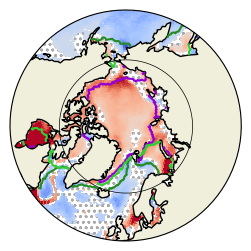

In [34]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(3,3)) 
# fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.5, color='black')
gl.ylocator = mticker.FixedLocator([66.5])
gl.xlocator = mticker.FixedLocator([])
pc = ax.pcolormesh(lon, lat, varichange, 
                   transform=ccrs.PlateCarree(), vmin = -60, vmax = 60,  #-60 60, -20 20
                   cmap='coolwarm', zorder = 1); #coolwarm, BrBG_r
this1=ax.contour(lon2d,lat2d,data_plt, levels = np.arange(0,3,1),
                 colors=['forestgreen','darkviolet'],linestyles='solid', linewidths=1.5,
                 transform=ccrs.PlateCarree(), zorder = 2)    
this2=ax.contour(lon2d,lat2d,data_plt2,levels = np.arange(0,3,1),
                 colors=['limegreen','violet'],linestyles='solid', linewidths=1.5, 
                 transform=ccrs.PlateCarree(), zorder = 2)    
# plt.scatter(189,72.5,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Chukchi
# plt.scatter(346.1,71.2,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Greenland
# plt.scatter(275.6,58.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Hudson
# plt.scatter(181.2,60.95,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Bering
# plt.scatter(289.4,85.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Central Arctic
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); #plt.colorbar(pc, orientation='horizontal', extend='both');
# plt.colorbar(pc, extend='both');
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/Fig2f.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()


In [47]:
yr2 = 13 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
varichange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            varichange[i,j] = np.nanstd(vari2[i,j,:]) - np.nanstd(vari[i,j,:])

/glade/derecho/scratch/cpayne/tmp/ipykernel_22517/3550086028.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_22517/3550086028.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


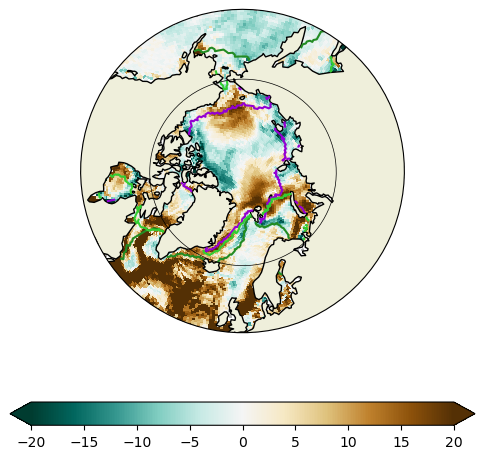

In [49]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# fig = plt.figure(figsize=(3,3)) 
fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.5, color='black')
gl.ylocator = mticker.FixedLocator([66.5])
gl.xlocator = mticker.FixedLocator([])
pc = ax.pcolormesh(lon, lat, varichange, 
                   transform=ccrs.PlateCarree(), vmin = -20, vmax = 20,  #-60 60, -20 20
                   cmap='BrBG_r', zorder = 1); #coolwarm, BrBG_r
this1=ax.contour(lon2d,lat2d,data_plt, levels = np.arange(0,3,1),
                 colors=['forestgreen','darkviolet'],linestyles='solid', linewidths=1.5,
                 transform=ccrs.PlateCarree(), zorder = 2)    
this2=ax.contour(lon2d,lat2d,data_plt2,levels = np.arange(0,3,1),
                 colors=['limegreen','violet'],linestyles='solid', linewidths=1.5, 
                 transform=ccrs.PlateCarree(), zorder = 2)    
# plt.scatter(189,72.5,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Chukchi
# plt.scatter(346.1,71.2,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Greenland
# plt.scatter(275.6,58.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Hudson
# plt.scatter(181.2,60.95,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Bering
# plt.scatter(289.4,85.9,transform=ccrs.PlateCarree(), facecolors='none', edgecolors='k', linewidth =2) #Central Arctic
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); plt.colorbar(pc, orientation='horizontal', extend='both');
# plt.colorbar(pc, extend='both');
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/FigS2cbar.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()


In [24]:
print(np.nansum(np.nanmean(vari2,axis=2)*areacello_ocn)/np.nansum(areacello_ocn),
      np.nansum(np.nanmean(vari,axis=2)*areacello_ocn)/np.nansum(areacello_ocn), 
      np.nansum(np.nanmean(vari2,axis=2)*areacello_ocn)/np.nansum(areacello_ocn)-
      np.nansum(np.nanmean(vari,axis=2)*areacello_ocn)/np.nansum(areacello_ocn))

69.1582493921348 69.81120325987499 -0.6529538677401803


/glade/derecho/scratch/cpayne/tmp/ipykernel_19735/2804858054.py:1: RuntimeWarning: Mean of empty slice
  print(np.nansum(np.nanmean(vari2,axis=2)*areacello_ocn)/np.nansum(areacello_ocn),
/glade/derecho/scratch/cpayne/tmp/ipykernel_19735/2804858054.py:2: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(vari,axis=2)*areacello_ocn)/np.nansum(areacello_ocn),
/glade/derecho/scratch/cpayne/tmp/ipykernel_19735/2804858054.py:3: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(vari2,axis=2)*areacello_ocn)/np.nansum(areacello_ocn)-
/glade/derecho/scratch/cpayne/tmp/ipykernel_19735/2804858054.py:4: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(vari,axis=2)*areacello_ocn)/np.nansum(areacello_ocn))


In [9]:
variens2 = np.zeros([50]); variens = np.zeros([50]); 
for ens in np.arange(0,50):
    variens2[ens] = np.nansum(vari2[:,:,ens]*areacello_ocn)
    variens[ens] = np.nansum(vari[:,:,ens]*areacello_ocn)
print(stats.ttest_rel(variens,variens2))

NameError: name 'vari2' is not defined

In [12]:
yr2 = 5 # 5 = 2020, 8 = 2050, 13 = 2100
data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
vari = max_25_2[0,:,:,:]-max_25[0,:,:,:]
vari2 = max_25_2[yr2,:,:,:]-max_25[yr2,:,:,:]
emergence = np.full([384,320],np.nan); highrange = np.full([384,320],np.nan); lowrange = np.full([384,320],np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(areacello_ocn[i,j]) == False:
            highrange[i,j] = np.nanmean(vari[i,j,:]) + (2*np.nanstd(vari[i,j,:]))
            lowrange[i,j] = np.nanmean(vari[i,j,:]) - (2*np.nanstd(vari[i,j,:]))
            if np.nanmean(vari2[i,j,:]) > highrange[i,j] or np.nanmean(vari2[i,j,:]) < lowrange[i,j]:
                emergence[i,j] = 1

/glade/derecho/scratch/cpayne/tmp/ipykernel_53454/3870441820.py:2: RuntimeWarning: Mean of empty slice
  data_plt = np.round(np.nanmean(si_ens_regrid[:,0,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_53454/3870441820.py:3: RuntimeWarning: Mean of empty slice
  data_plt2 = np.round(np.nanmean(si_ens_regrid[:,yr2,:,:],axis=0),0)
/glade/derecho/scratch/cpayne/tmp/ipykernel_53454/3870441820.py:10: RuntimeWarning: Mean of empty slice
  highrange[i,j] = np.nanmean(vari[i,j,:]) + (2*np.nanstd(vari[i,j,:]))
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/cpayne/tmp/ipykernel_53454/3870441820.py:11: RuntimeWarning: Mean of empty slice
  lowrange[i,j] = np.nanmean(vari[i,j,:]) - (2*np.nanstd(vari[i,j,:]))


In [82]:
print(np.nansum(emergence * arctic_ocn)/np.nansum(arctic_ocn),np.nansum(emergence * areacello_ocn)/np.nansum(areacello_ocn))


0.009958256021864786 0.014158619540433532


In [ ]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(4,4)) 
# fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])
pc = ax.pcolormesh(lon, lat, emergence, 
                   transform=ccrs.PlateCarree(), zorder = 1); 
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); 
# plt.colorbar(pc, orientation='horizontal', extend='both');